In [2]:
%%time
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
from dataclasses import dataclass
from pathlib import Path

import pandas as pd
from dotenv import load_dotenv


@dataclass
class Config:
    project_dir: Path = Path("../../")
    model_dir: Path = project_dir / "models"
    outputs_dir: Path = project_dir / "outputs"
    results_dir: Path = project_dir / "results"
    results_agg_dir: Path = results_dir / "agg"
    results_figs_dir: Path = results_dir / "figs"
    data_dir: Path = project_dir / "data"
    raw_dir: Path = data_dir / "raw"
    interim_dir: Path = data_dir / "interim"
    processed_dir: Path = data_dir / "processed"


config = Config()
sys.path.append(str(config.project_dir.resolve()))
load_dotenv()

CPU times: user 285 ms, sys: 95.5 ms, total: 380 ms
Wall time: 632 ms


True

In [3]:
df_order_info_details = pd.read_csv(config.processed_dir / "order_info_details.csv")
df_reviews = pd.read_csv(
    config.interim_dir
    / "olist_order_reviews_translated_label_review_categories_merged.csv",
)
df_reviews_last = df_reviews.groupby("order_id").last().reset_index()
df_order_info_details_reviews_merged = pd.merge(
    df_order_info_details, df_reviews_last, on="order_id", how="left"
)
assert df_order_info_details_reviews_merged.shape[0] == df_order_info_details.shape[0]
for col in [
    "order_purchase_timestamp",
    "order_approved_at",
    "order_delivered_carrier_date",
    "order_delivered_customer_date",
    "order_estimated_delivery_date",
    "shipping_limit_date",
]:
    df_order_info_details_reviews_merged[col] = pd.to_datetime(
        df_order_info_details_reviews_merged[col],
        format="mixed",
    )
df_review_no_null = df_order_info_details_reviews_merged.dropna(
    subset=["review_comment_message_en"]
)
print(f"df_review_no_null.shape: {df_review_no_null.shape}")


df_review_no_null.shape: (40818, 90)


In [4]:
df_target = (
    df_review_no_null.query(
        "review_categories_str_modified in ['Delivery_Issue','Delivery_Praise'] "
    )
    .query("customer_state in ['SP','RJ']")
    .dropna(subset=["order_delivered_customer_date_span_from_delivery_carrier"])
)

df_target["is_same_state"] = (
    df_target["customer_state"] == df_target["seller_state"]
).astype(int)
df_target["is_same_city"] = (
    df_target["customer_city"] == df_target["seller_city"]
).astype(int)


df_target["freight_ratio"] = (
    df_target["sum_freight"] / df_target["sum_price_freight_by_order"]
)

## 全体

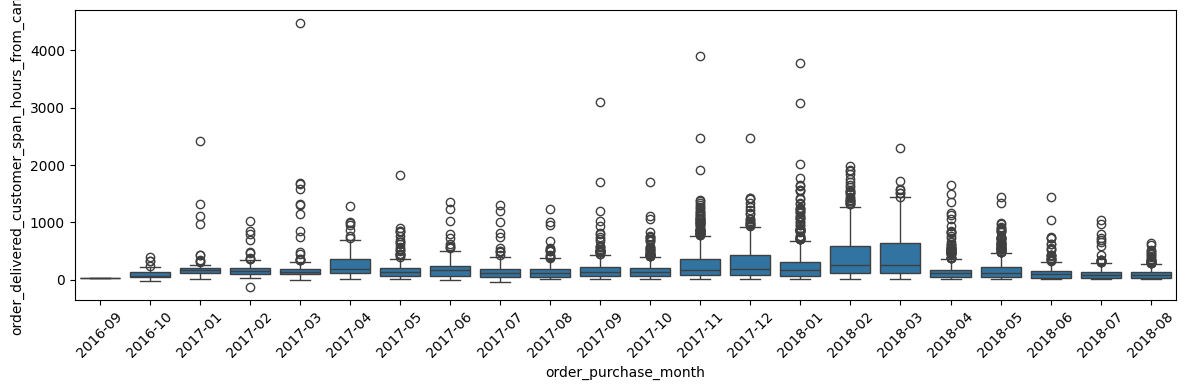

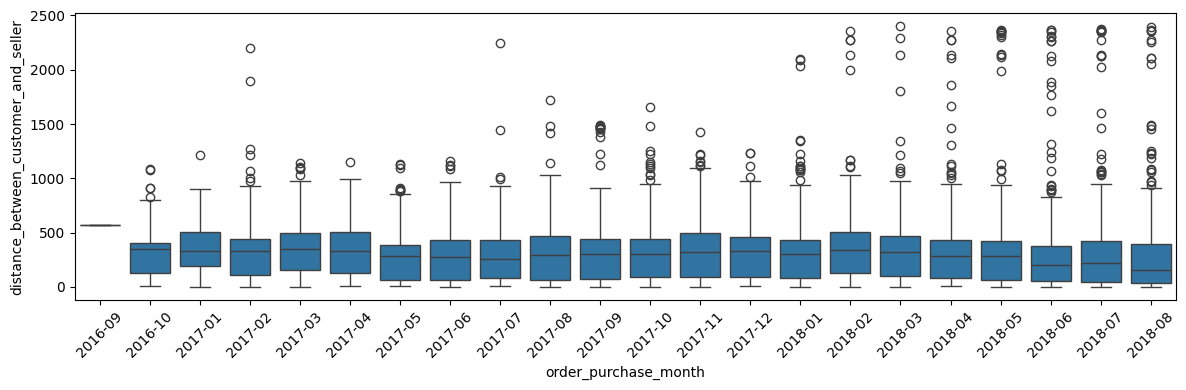

/Users/shim-kojio/Desktop/ey_sat_lab/.venv/lib/python3.11/site-packages/matplotlib/collections.py:1008: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/Users/shim-kojio/Desktop/ey_sat_lab/.venv/lib/python3.11/site-packages/matplotlib/collections.py:1008: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


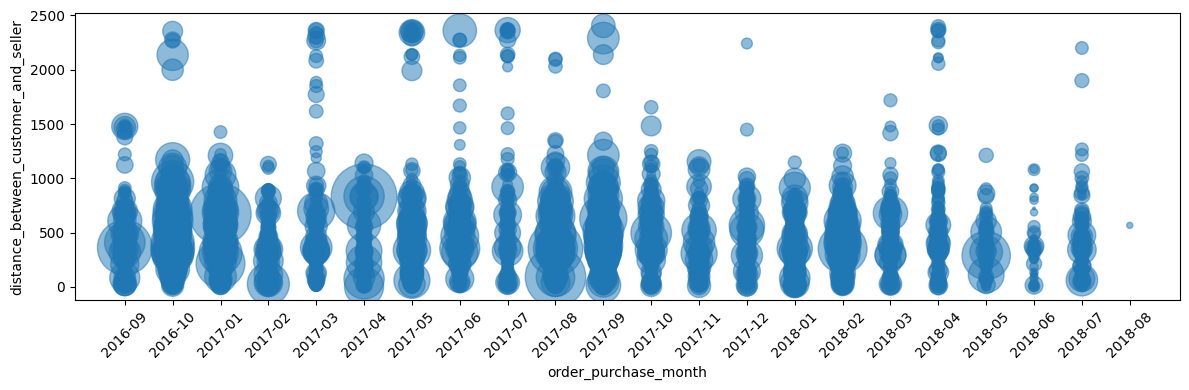

In [37]:
# プロットのサイズを設定
plt.figure(figsize=(12, 4))

# データをソートして箱ひげ図を作成
sns.boxplot(
    data=df_target,
    x="order_purchase_month",
    y="order_delivered_customer_span_hours_from_carrier",
    order=sorted(df_target["order_purchase_month"].unique()),  # x軸のデータをソート
)

plt.xlabel("order_purchase_month")
plt.ylabel("order_delivered_customer_span_hours_from_carrier")
plt.xticks(rotation=45)  # x軸のラベルを45度回転

# 余白を調整
plt.tight_layout()

plt.show()

# プロットのサイズを設定
plt.figure(figsize=(12, 4))

# データをソートして箱ひげ図を作成
sns.boxplot(
    data=df_target,
    x="order_purchase_month",
    y="distance_between_customer_and_seller",
    order=sorted(df_target["order_purchase_month"].unique()),  # x軸のデータをソート
)

plt.xlabel("order_purchase_month")
plt.ylabel("distance_between_customer_and_seller")
plt.xticks(rotation=45)  # x軸のラベルを45度回転

# 余白を調整
plt.tight_layout()

plt.show()

# プロットのサイズを設定
plt.figure(figsize=(12, 4))

# scatter plotを作成
plt.scatter(
    data=df_target,
    x="order_purchase_month",
    y="distance_between_customer_and_seller",
    s=df_target["order_delivered_customer_span_hours_from_carrier"]
    / 2,  # 点の大きさを配送時間に設定
    alpha=0.5,  # 透明度を設定
)

plt.xlabel("order_purchase_month")
plt.ylabel("distance_between_customer_and_seller")
plt.xticks(rotation=45)  # x軸のラベルを45度回転

# x軸の値をソート
plt.gca().set_xticks(range(len(sorted(df_target["order_purchase_month"].unique()))))
plt.gca().set_xticklabels(sorted(df_target["order_purchase_month"].unique()))

# 余白を調整
plt.tight_layout()

plt.show()

In [31]:
df_target.sort_values(
    by="order_delivered_customer_span_hours_from_carrier", ascending=False
).to_csv(config.results_agg_dir / "df_target_sorted.csv", index=False)

## 商品カテゴリー別

category:  watches_gifts


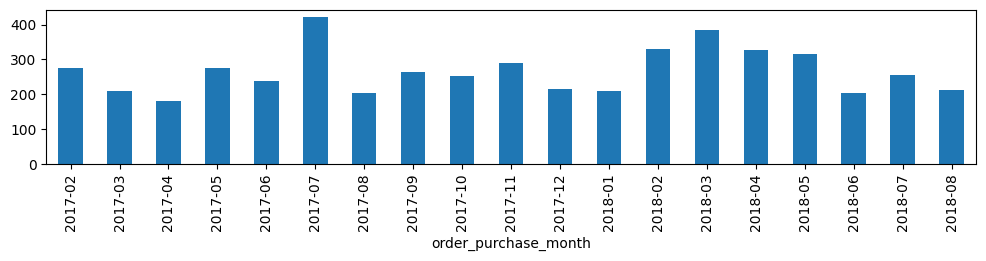

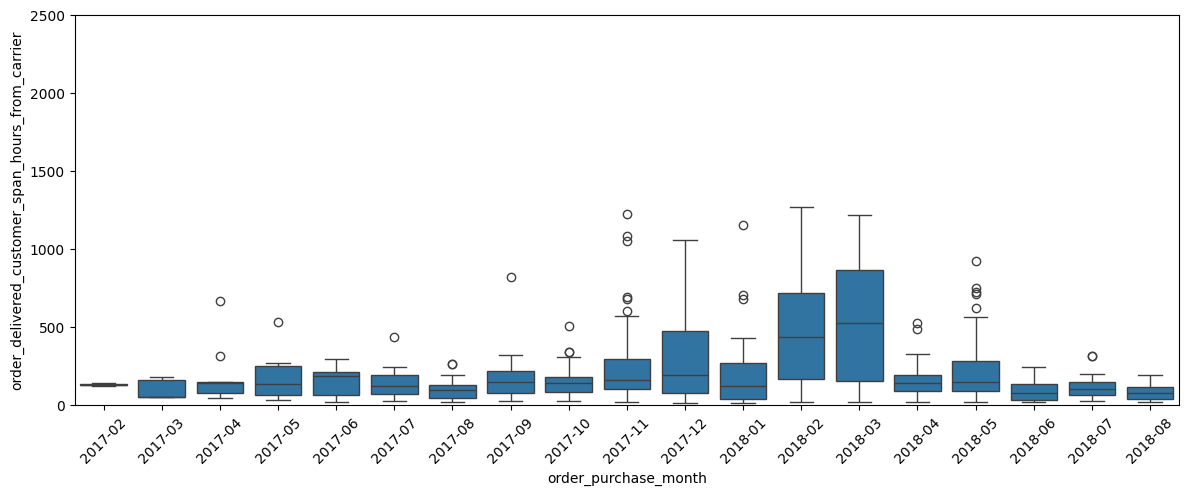

--------------------
category:  cool_stuff


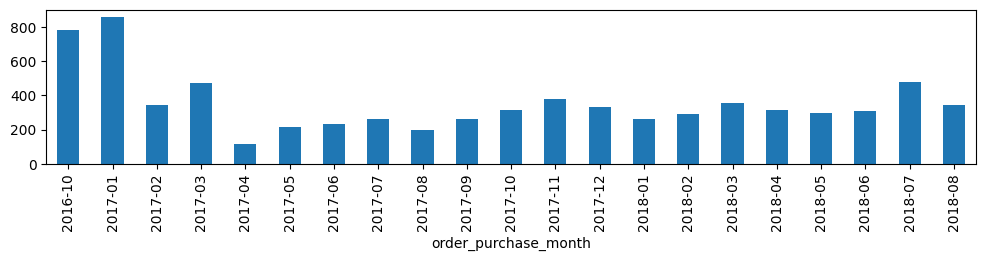

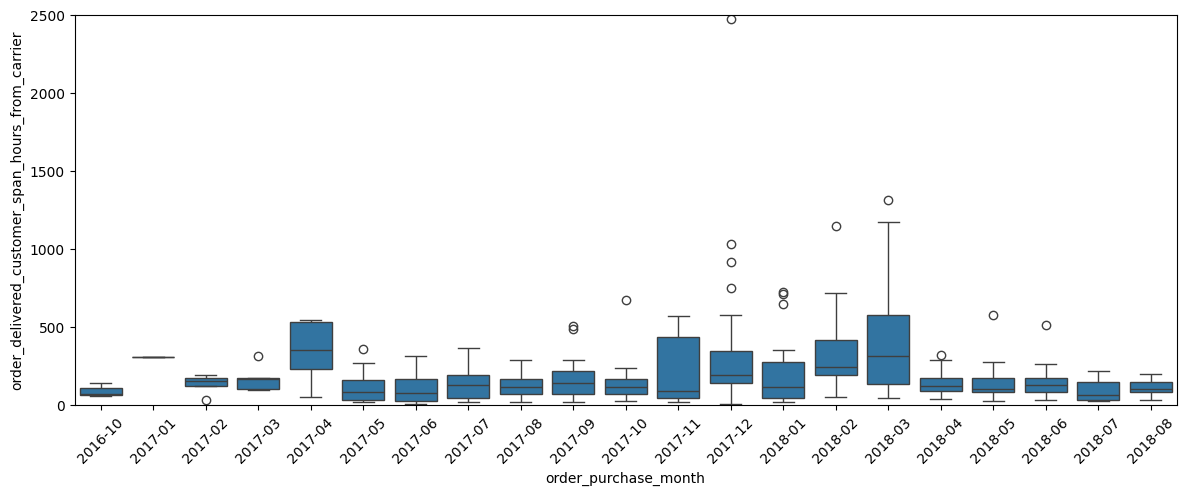

--------------------
category:  toys


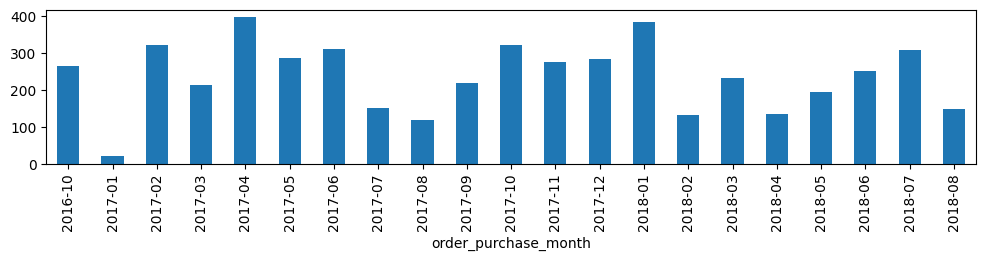

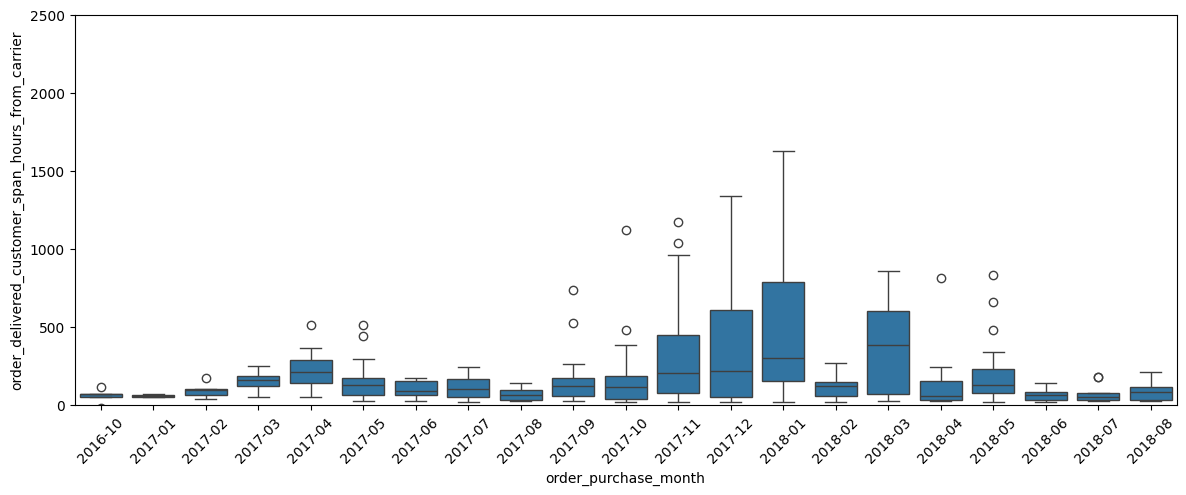

--------------------
category:  sports_leisure


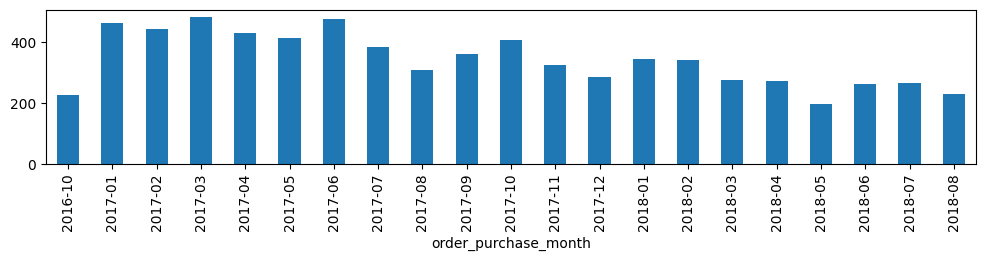

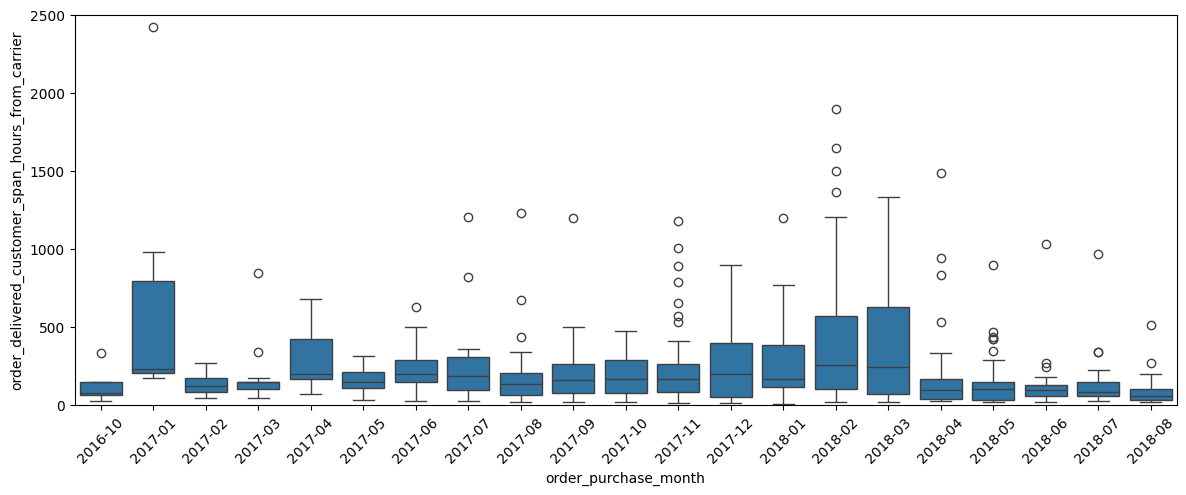

--------------------
category:  bed_bath_table


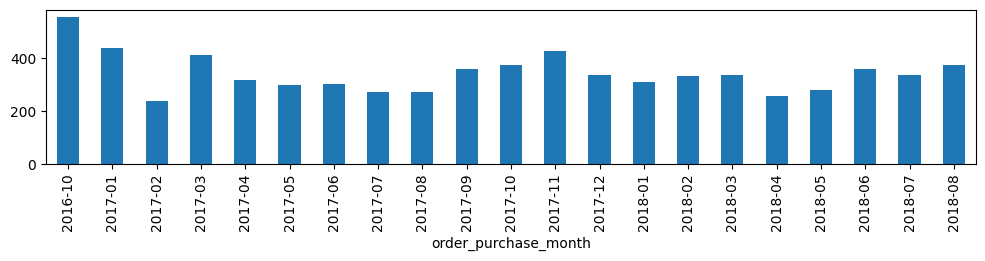

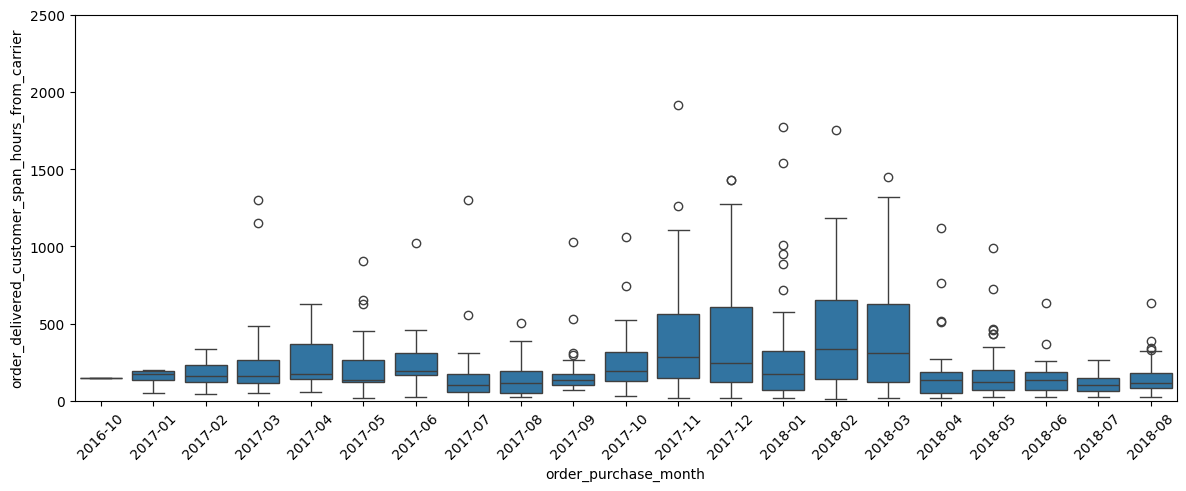

--------------------
category:  computers_accessories


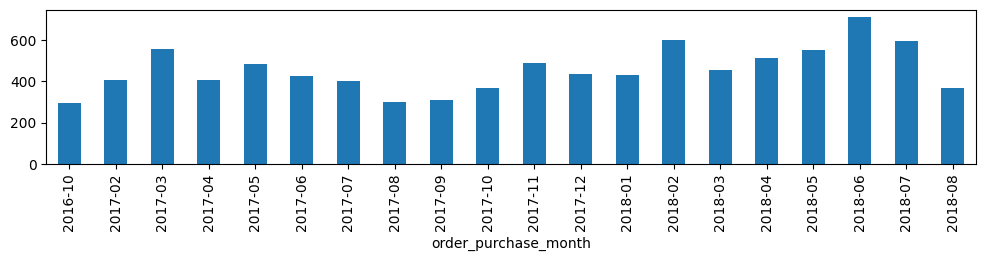

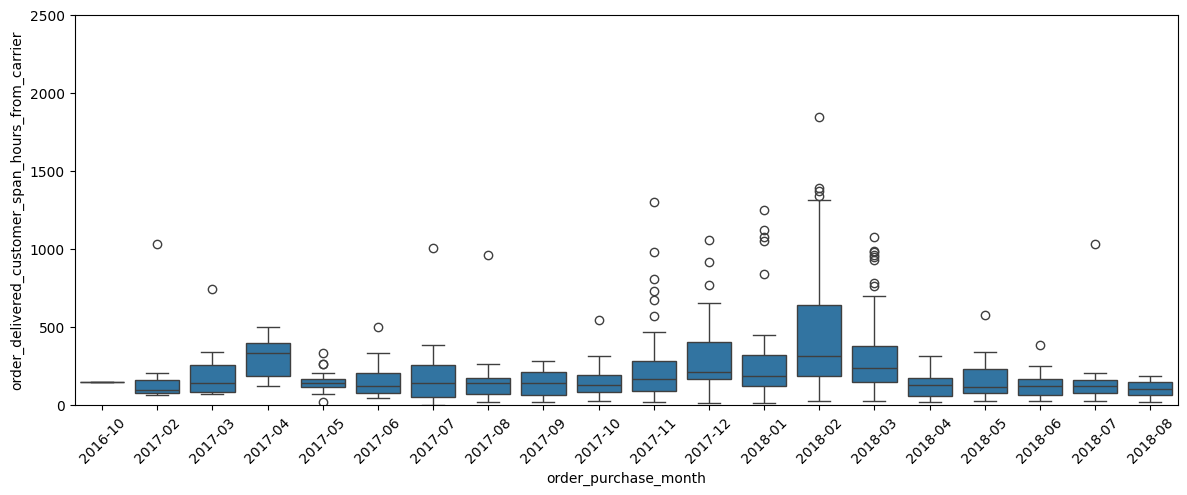

--------------------


In [77]:
low_growth_categories = [
    "watches_gifts",
    "cool_stuff",
    "toys",
    "sports_leisure",
    "bed_bath_table",
    "computers_accessories",
]

for category in low_growth_categories:
    print("category: ", category)
    df_target_category = df_target.query("product_category_name_english == @category")
    df_target_category.groupby("order_purchase_month")[
        "distance_between_customer_and_seller"
    ].mean().plot.bar(figsize=(12, 2))
    # プロットのサイズを設定
    plt.figure(figsize=(12, 5))

    # データをソートして箱ひげ図を作成
    sns.boxplot(
        data=df_target_category,
        x="order_purchase_month",
        y="order_delivered_customer_span_hours_from_carrier",
        order=sorted(
            df_target_category["order_purchase_month"].unique()
        ),  # x軸のデータをソート
    )

    plt.xlabel("order_purchase_month")
    plt.ylabel("order_delivered_customer_span_hours_from_carrier")
    plt.xticks(rotation=45)  # x軸のラベルを45度回転

    # 余白を調整
    plt.tight_layout()
    plt.ylim(0, 2500)

    plt.show()

    print("--------------------")

category:  watches_gifts


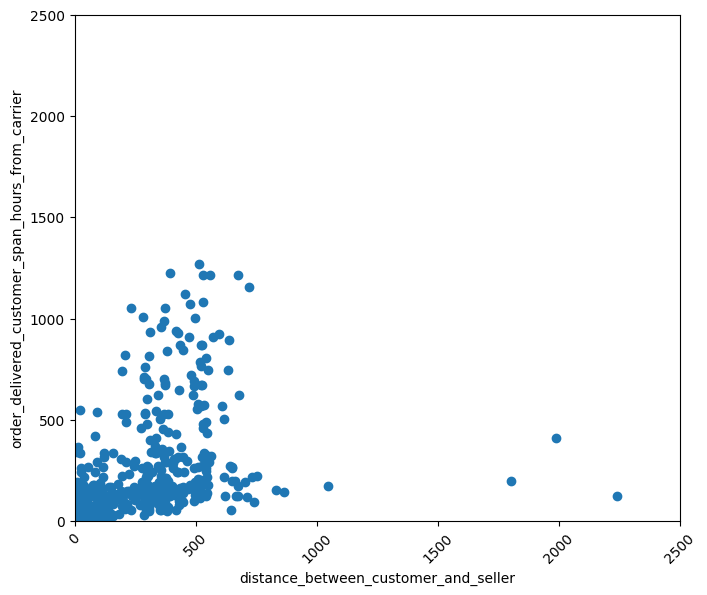

--------------------
category:  cool_stuff


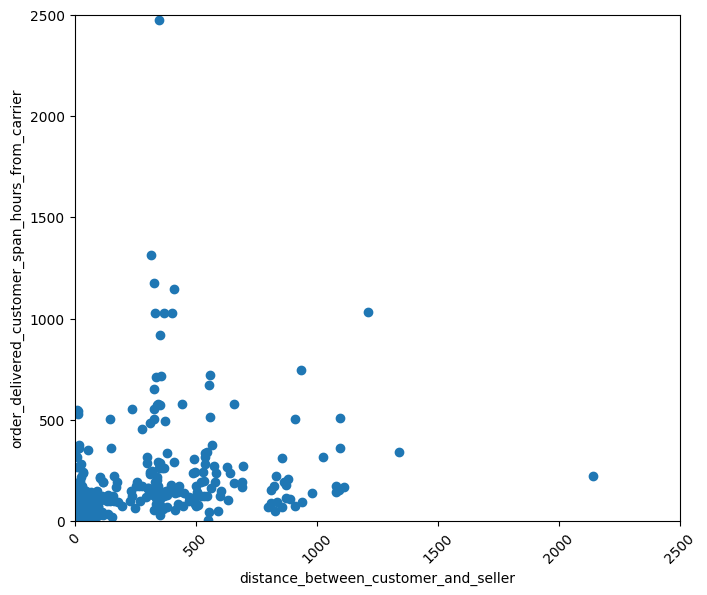

--------------------
category:  toys


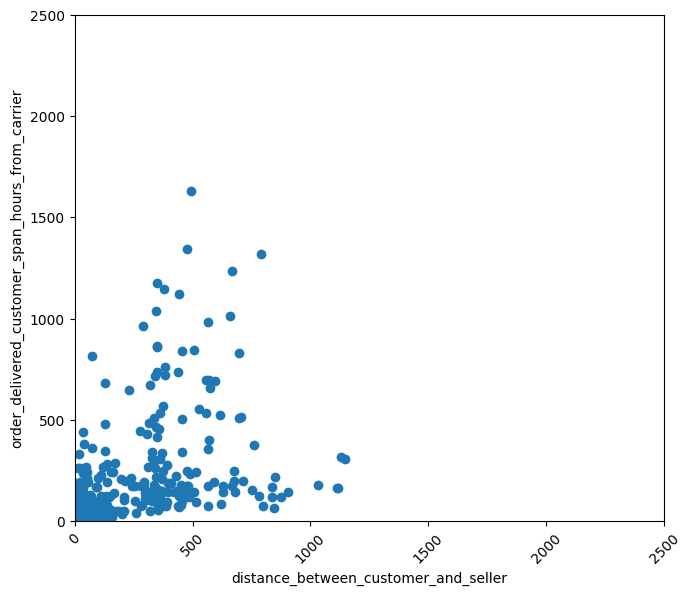

--------------------
category:  sports_leisure


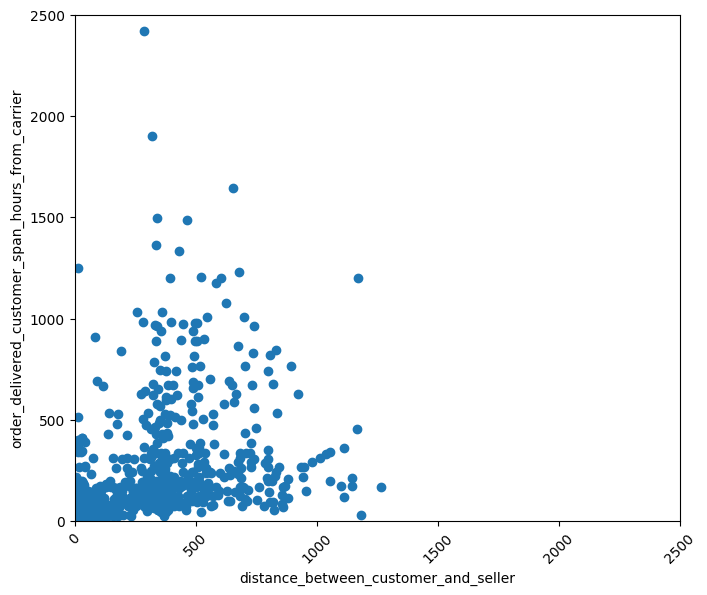

--------------------
category:  bed_bath_table


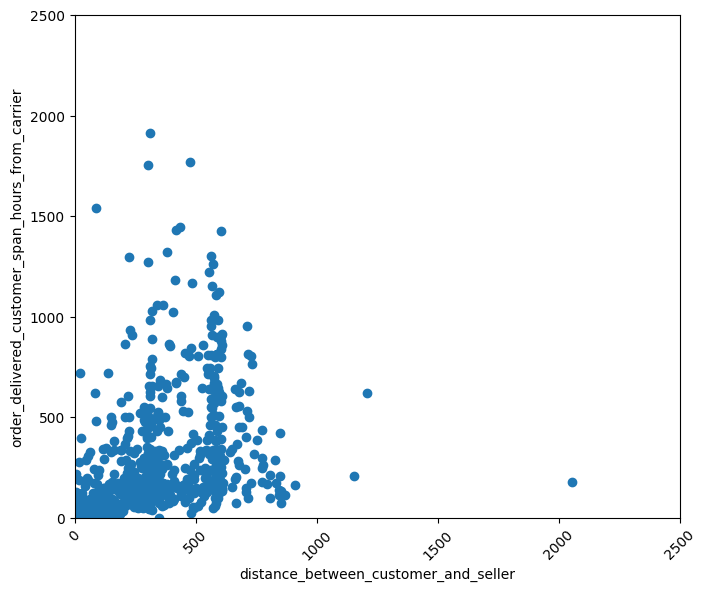

--------------------
category:  computers_accessories


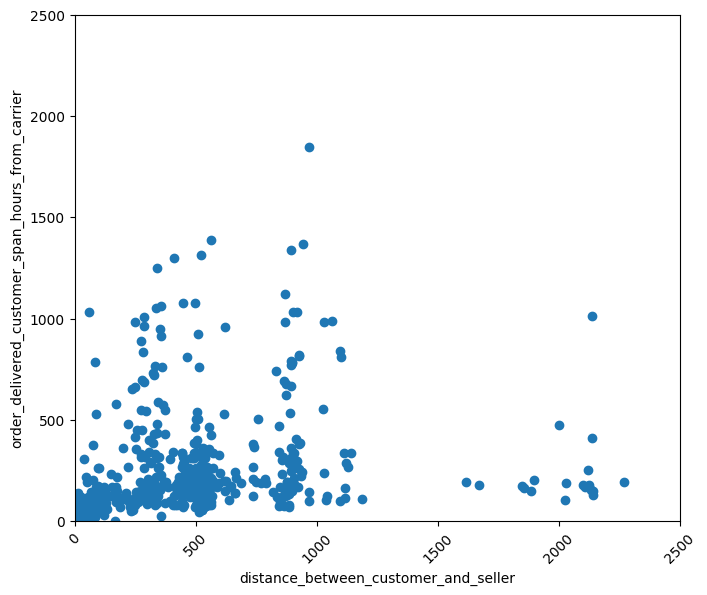

--------------------


In [69]:
low_growth_categories = [
    "watches_gifts",
    "cool_stuff",
    "toys",
    "sports_leisure",
    "bed_bath_table",
    "computers_accessories",
]

for category in low_growth_categories:
    print("category: ", category)
    df_target_category = df_target.query("product_category_name_english == @category")
    # プロットのサイズを設定
    plt.figure(figsize=(7, 6))

    # データをソートして箱ひげ図を作成
    plt.scatter(
        df_target_category["distance_between_customer_and_seller"],
        df_target_category["order_delivered_customer_span_hours_from_carrier"],
    )

    plt.xlabel("distance_between_customer_and_seller")
    plt.ylabel("order_delivered_customer_span_hours_from_carrier")
    plt.xticks(rotation=45)  # x軸のラベルを45度回転

    # 余白を調整
    plt.tight_layout()
    plt.ylim(0, 2500)
    plt.xlim(0, 2500)
    plt.show()
    print("--------------------")

In [ ]:
df_target.query("product_category_name_english == '')


In [56]:
df_target[
    [
        "distance_between_customer_and_seller",
        "order_delivered_customer_span_hours_from_carrier",
    ]
].corr()

,distance_between_customer_and_seller,order_delivered_customer_span_hours_from_carrier
distance_between_customer_and_seller,1.0000,0.2737
order_delivered_customer_span_hours_from_carrier,0.2737,1.0000


In [57]:
df_target.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'order_purchase_month', 'order_purchase_date', 'order_purchase_weekday',
       'order_approved_month', 'order_approved_date', 'order_approved_weekday',
       'order_delivered_carrier_month', 'order_delivered_carrier_weekday',
       'order_delivered_customer_month', 'order_delivered_customer_weekday',
       'order_estimated_delivery_month', 'order_estimated_delivery_weekday',
       'approved_span', 'estimated_delivery_span',
       'order_delivered_carrier_date_span_from_purchase',
       'order_delivered_customer_date_span_from_purchase',
       'order_delivered_customer_date_span_from_delivery_carrier',
       'is_delivery_to_customers_delayed', 'customer_unique_id',
       'customer_zip_code_prefix', 'customer_city', 'customer_state',
       'total_payment_value', 

<Axes: xlabel='order_estimated_delivery_span_hours_from_carrier', ylabel='order_delivered_customer_span_hours_from_carrier'>

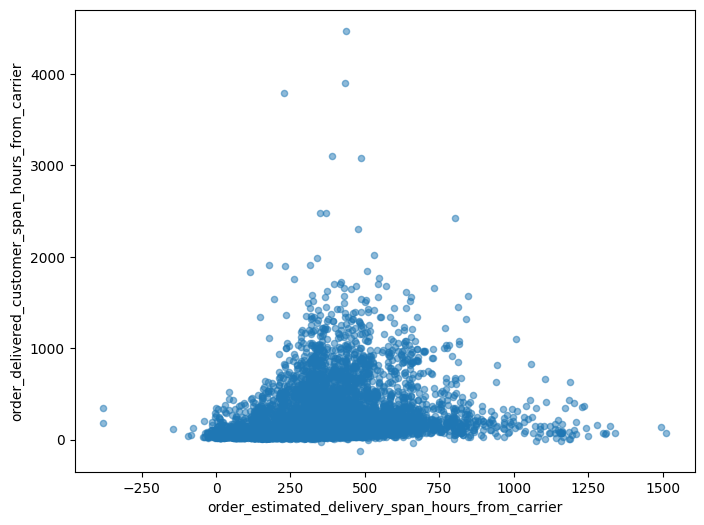

In [66]:
df_target.plot.scatter(
    x="order_estimated_delivery_span_hours_from_carrier",
    y="order_delivered_customer_span_hours_from_carrier",
    figsize=(8, 6),
    alpha=0.5,
)